### MAP556, Ecole Polytechnique, 2022-23

# PC7 - Construction and training of feed-forward Neural Networks

This notebook illustrates the construction and training of a multi-layer neural network in Python, using only basic libraries such as numpy.

We will construct a NN $T_\theta(x)$ and then, given some synthetic data $(x_i, y_i)_{i = 1, \dots, N}$, solve the fitting (or training) problem

$$
\min_\theta R_N(\theta) \quad \mbox{where} \quad R_N(\theta) = \frac 1 N \sum_{i=1}^N (y_i -  T_\theta(x_i))^2
$$

applying a gradient descent algorithm


$$
\theta_{n+1} = \theta_n - \eta \, \frac 1{\left|B_{n+1} \right|} \sum_{i \in B_{n+1}}^N \nabla_\theta \, (y_i -  T_{\theta_n}(x_i))^2 
$$

with step (or "learning rate") $\eta$, where $(B_{n})_n$ is a sequence of batches.

This procedure will require to implement the computation of the gradient $\nabla_\theta T(x_i)$, which can be done by backpropagation through the network.

In [50]:
import numpy as np
import matplotlib.pyplot as plt

### Network construction

We recall the notation from the lectures: a NN $T_\theta$ is a composition of $L$ transformations $(T^l)_{l = 1, \dots, L}$

$$
T_\theta = T^L \circ \cdots \circ T^1,
$$

where, for each $l$, $T^l : \mathbb R^{d^l} \to \mathbb R^{d^{l+1}}$ is given by

$$
T^l(x) = \sigma^l \left(W^l x + b^l \right).
$$

The matrices $W^l \in \mathbb R^{d^{l+1} \times d^l}$ are called the network _weights_, the vectors $b^l \in \mathbb R^{d^{l+1}}$  the network _biases_.

The activation function $\sigma^l$ acts componentwise, $\sigma^l(a) = (\sigma^l(a_1), \dots, \sigma^l(a_{d^{l+1}}))$.

In [3]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

The following class implements the linear transformation part of a generic layer within the network (a separate class will be used to implement the activation function).

In [68]:
# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        # Random initialisation of the layer weight parameters
        # (note that, using the notation of the lectures, self.weights corresponds to W.T).
        self.weights = np.random.rand(input_size, output_size) - 0.5
        
        # Random initialisation of the layer bias parameters b
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):        
        # The input data is copied into the layer
        self.input = input_data
        
        # Note that output is implemented as x * W instead of W * x
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # Recall the notation from the lectures :
    # - the transformation from layer input x to layer output y is denoted T.
    # The fct below computes dT/dW, dT/dB for a given output_error dT/dy. Returns input_error=dT/dX.
    def backward_propagation(self, output_error):
        assert output_error.shape == self.bias.shape
        
        self.bias_error = output_error
        self.weights_error = np.dot(self.input.T, output_error) # shape = input_size * output_size
        
        self.input_error = np.dot(output_error, self.weights.T) # shape = 1 * input_size
        
        # We need to output the value of dT/dX so that it can be used by the following layer
        # within the backpropagation algorithm
        return self.input_error
        
    # perform one gradient step and update parameters
    def gradient_step(self, learning_rate):
        self.weights -= learning_rate * self.weights_error
        self.bias -= learning_rate * self.bias_error

Let us test our FCLayer class

In [46]:
FClayer1 = FCLayer(2, 3)

print("FClayer1.weights.shape : ", FClayer1.weights.shape)
print("FClayer1.weights : \n", FClayer1.weights, "\n")

print("FClayer1.bias.shape : ", FClayer1.bias.shape)
print("FClayer1.bias: \n", FClayer1.bias, "\n")

# test forward computation
input_data = np.array([[1, 2]])
layer_output = FClayer1.forward_propagation(input_data)
print("layer_output : ", layer_output, "\n")

# test backward computation
input_derivative = FClayer1.backward_propagation(np.array([[1, 2, 3]]))
print("derivative w.r.t. input : ", input_derivative, "\n")

# test parameters update
FClayer1.gradient_step(0.1)
print("Updated FClayer1.weights : \n", FClayer1.weights)

FClayer1.weights.shape :  (2, 3)
FClayer1.weights : 
 [[ 0.09891396 -0.4201205   0.49898018]
 [ 0.14531076 -0.32767259  0.40285565]] 

FClayer1.bias.shape :  (1, 3)
FClayer1.bias: 
 [[ 0.29846642  0.12666811 -0.02791349]] 

layer_output :  [[ 0.6880019  -0.94879757  1.27677799]] 

derivative w.r.t. input :  [[1.88205411 1.14090278]] 

Updated FClayer1.weights : 
 [[-0.00108604 -0.6201205   0.19898018]
 [-0.05468924 -0.72767259 -0.19714435]]


__Activation function__. The following class implements the activation function as an additional layer inside the NN (with input size = output size).

In [48]:
# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        # The input data is copied into the layer
        self.input = input_data
        
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # The learning_rate is not used because there is no "learnable" parameter within the activation function.
    def backward_propagation(self, output_error):
        return self.activation_prime(self.input) * output_error

Let us test the ActivationLayer class

In [55]:
# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

ActivationLayer1 = ActivationLayer(tanh, tanh_prime)

print("output : ", ActivationLayer1.forward_propagation( np.array([[1, 2]]) ) )

print("derivative w.r.t. input : " , ActivationLayer1.backward_propagation( np.array([[1, 2]]) ) )

output :  [[0.76159416 0.96402758]]
derivative w.r.t. input :  [[0.41997434 0.14130165]]


In [56]:
# Loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2*(y_pred - y_true)/y_true.size

__Full network and training functions__. Finally, we implement the full network, allowing for the possibility to pile up layers made by linear transformations and activation functions.

In [66]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # compute output for given input
    def predict(self, input_data):
        # detect the sample dimension first
        sample_lenght = len(input_data)
        result = []

        # run network over all samples
        for i in range(sample_lenght):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        sample_lenght = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(sample_lenght):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error)
                    if hasattr(layer, 'gradient_step') and callable(getattr(layer, 'gradient_step')):
                        layer.gradient_step(learning_rate)

            # calculate average error on all samples (for display purpose only)
            err /= sample_lenght
            if i % 100 == 0:
                print('epoch %d/%d  error=%f' % (i+1, epochs, err))

### Test on synthetic data

We test the network training on some toy examples.

__First example__. As a start, we fit a small NN with one hidden layer to a function $y(x)$ defined on the vertices of the square $[0,1]^2$

(Of course this is a very simple example, and the NN will be able to perform well - but already in this basic situation, we will see the importance of hyperparameters such as the random initialisation of the network and the learning rate.)

In [69]:
# training data
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

print("x_train.shape : ", x_train.shape)
print("len(x_train) : ", len(x_train))

print("y_train.shape :", y_train.shape)

x_train.shape :  (4, 1, 2)
len(x_train) :  4
y_train.shape : (4, 1, 1)


In [82]:
# network
input_size = x_train.shape[-1]
output_size = y_train.shape[-1]

net = Network()

net.add(FCLayer(input_size, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, output_size))
net.add(ActivationLayer(tanh, tanh_prime))

# starting point 
print("Initial network output y :", net.predict(x_train), "\n")

# train
net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# the resulting output
result = net.predict(x_train)
print("\n Trained network output y :", result)

Initial network output y : [array([[-0.27685922]]), array([[-0.30001439]]), array([[-0.17115303]]), array([[-0.2085368]])] 

epoch 1/1000  error=0.601549
epoch 101/1000  error=0.213137
epoch 201/1000  error=0.020314
epoch 301/1000  error=0.002282
epoch 401/1000  error=0.001089
epoch 501/1000  error=0.000697
epoch 601/1000  error=0.000506
epoch 701/1000  error=0.000395
epoch 801/1000  error=0.000323
epoch 901/1000  error=0.000272
Trained network output y : [array([[0.00075837]]), array([[0.97808587]]), array([[0.97866773]]), array([[-0.00124631]])]


__Another example__.  Here we ask a NN to fit some noisy observations of the function $y(x) = \sin(4 \, x)$.

Text(0.5,1,'Training data')

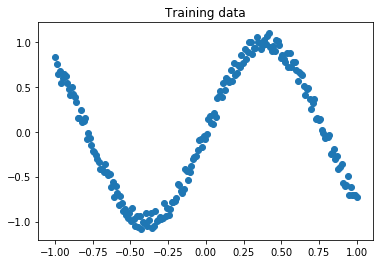

In [99]:
# training data
n_sample = 200
x_train = np.linspace(-1, 1, n_sample)
y_train = np.sin(x_train*4) + np.random.uniform(-0.1, 0.1, n_sample)

# plot the training data
plt.scatter(x_train, y_train)
plt.title("Training data")
plt.show()

initial_output.shape :  (200, 1, 1)


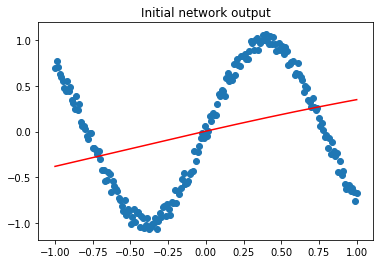

epoch 1/1000  error=0.013987
epoch 101/1000  error=0.008544
epoch 201/1000  error=0.006878
epoch 301/1000  error=0.006412
epoch 401/1000  error=0.006205
epoch 501/1000  error=0.006112
epoch 601/1000  error=0.006055
epoch 701/1000  error=0.006016
epoch 801/1000  error=0.005987
epoch 901/1000  error=0.005966


Text(0.5,1,'Trained network output')

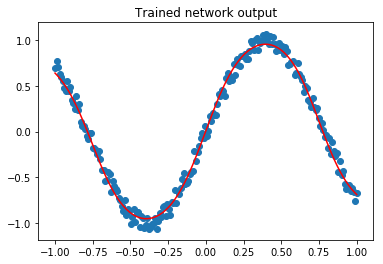

In [98]:
# network
nb_neurons = 10

net = Network()

net.add(FCLayer(1, nb_neurons))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(nb_neurons, 1))
#net.add(ActivationLayer(tanh, tanh_prime))

# starting point 
initial_output = net.predict(x_train)
print("initial_output.shape : ", np.array(initial_output).shape )

plt.scatter(x_train, y_train)
plt.plot(x_train, np.squeeze(initial_output), 'r')
plt.title("Initial network output")
plt.show()

# train
net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# plot the resulting output
result = net.predict(x_train)

plt.scatter(x_train, y_train)
plt.plot(x_train, np.squeeze(result), 'r')
plt.title("Trained network output")
plt.show()